In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import re
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
import torch
import copy
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertModel,get_linear_schedule_with_warmup
from torch.optim import AdamW
import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
file_path = "/content/gdrive/My Drive/BT 5153 Final Project"
kaggle_ds = pd.read_csv(file_path + "/twitter_MBTI.csv")
tianchi_ds = pd.read_csv(file_path + "/mbti_1.csv")

In [ ]:
kaggle_ds.head()

,Unnamed: 0,text,label
0,0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,1,@Hispanthicckk Being you makes you look cute||...,intj
2,2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


In [ ]:
tianchi_ds.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
kaggle_ds.drop(columns=["Unnamed: 0"], inplace=True)
kaggle_ds.columns = ["post", "type"]

tianchi_ds.columns = ["type", "post"]

In [ ]:
kaggle_ds.head()

,post,type
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj
1,@Hispanthicckk Being you makes you look cute||...,intj
2,@Alshymi Les balles sont réelles et sont tirée...,intj
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj


In [ ]:
tianchi_ds.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
kaggle_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811 entries, 0 to 7810
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   post    7811 non-null   object
 1   type    7811 non-null   object
dtypes: object(2)
memory usage: 122.2+ KB


In [ ]:
tianchi_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   post    8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [ ]:
kaggle_ds.isnull().sum()

,0
post,0
type,0


In [ ]:
tianchi_ds.isnull().sum()

,0
type,0
post,0


In [ ]:
def explode_column(df, col_to_explode, sep = r"\|\|\|"):
    """
    Split the specified column of a DataFrame into multiple rows by a separator,
    preserving all other columns unchanged.

    param
    ----
    df : imported dataframes
    col_to_explode : str columns want to split
    sep : str regularize expression for "|||"
    """
    df_copy = df.copy()
    # 1) split the text with "|||"
    df_copy[col_to_explode] = df_copy[col_to_explode].str.split(sep)
    # 2) explode
    df_exploded = df_copy.explode(col_to_explode)
    # 3) reset index
    return df_exploded.reset_index(drop=True)

In [ ]:
df1 = explode_column(kaggle_ds, "post")
df2 = explode_column(tianchi_ds, "post")

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093199 entries, 0 to 1093198
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   post    1093199 non-null  object
 1   type    1093199 non-null  object
dtypes: object(2)
memory usage: 16.7+ MB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422845 entries, 0 to 422844
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   type    422845 non-null  object
 1   post    422845 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [ ]:
df = pd.concat([df1, df2], ignore_index=True)

In [ ]:
df["type"].unique()


array(['intj', 'intp', 'entj', 'entp', 'infj', 'infp', 'enfj', 'enfp',
       'istj', 'isfj', 'estj', 'esfj', 'istp', 'isfp', 'estp', 'esfp',
       'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

In [ ]:
def clean_text(text):
  """
  clean to text, to lower case, remove abnormal characters or strings like http, @, *, #, etc
  input: str
  output: str
  """
  text = text.lower() #to lower case
  text = re.sub(r"https?://\S+", "", text) #remove links
  text = re.sub(r"@\w+", "", text) #remove @nickname
  text = re.sub(r"#\w+", "", text) #remove 话题
  text = re.sub(r"&amp;|&lt;|&gt;", "", text) #remove all HTML specific entities, avoid left in post
  text = re.sub(r"[^0-9a-zA-Z\s.,!?;:'\"()\[\]{}]", "", text) #keep only numbers, letters, and  punctuaion
  text = re.sub(r"\s+", " ", text).strip() #only keep one space if there are multiple
  return text

In [ ]:
df["post"] = df["post"].apply(clean_text)
df['type']=df['type'].apply(clean_text)

In [ ]:
df

,post,type
0,"the pope is infallible, this is a catholic dog...",intj
1,and by perpetually it entails that the church ...,intj
2,you open the door to unironic nonsense when yo...,intj
3,you dont know your own faith lol you just trie...,intj
4,thats like me saying that im gonna give you a ...,intj
...,...,...
1516039,i was going to close my facebook a few months ...,infp
1516040,30 seconds to mars all of my collections. it s...,infp
1516041,"i have seen it, and i agree. i did actually th...",infp
1516042,ok so i have just watched underworld 4 (awaken...,infp


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516044 entries, 0 to 1516043
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   post    1516044 non-null  object
 1   type    1516044 non-null  object
dtypes: object(2)
memory usage: 23.1+ MB


### Visualization

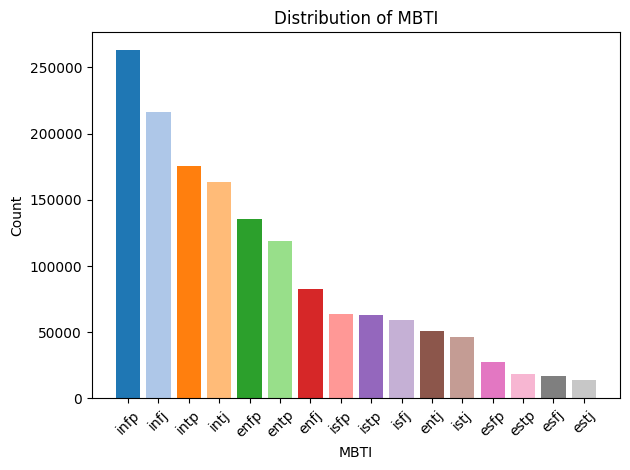

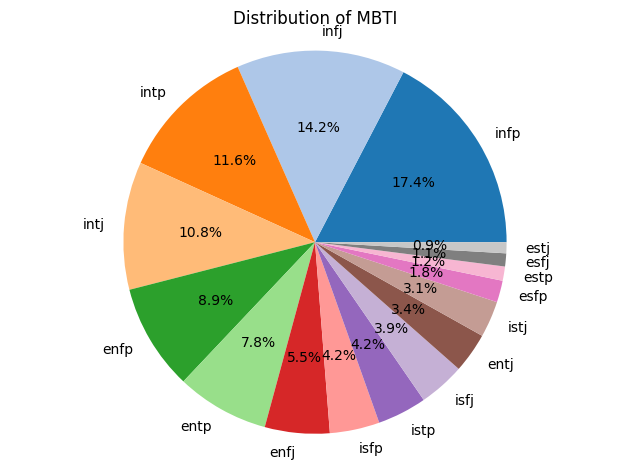

In [ ]:
counts = df['type'].value_counts()
# The variable 'sizes' was not defined.
# Assuming it should represent the counts of each MBTI type, we can replace it with 'counts.values'
colors = plt.get_cmap('tab20')(range(len(counts.values)))

#plot bar plot
plt.figure()
plt.bar(counts.index.astype(str), counts.values, color=colors)
plt.title('Distribution of MBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(counts.values, labels=counts.index.astype(str),colors=colors, autopct='%1.1f%%')
plt.title('Distribution of MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
le = LabelEncoder()
df["label_16"] = le.fit_transform(df["type"])  # 0–15

In [ ]:
#四维encoding
df['E'] = df["type"].str[0].map({"e":1, "i":0})
df['N'] = df["type"].str[1].map({"n":1, "s":0})
df['T'] = df["type"].str[2].map({"t":1, "f":0})
df['P'] = df["type"].str[3].map({"p":1, "j":0})


In [ ]:
# 统计每种特质的数量
total = len(df)
indi_char_count = {
    'E': int(df['E'].sum()),
    'I': total - int(df['E'].sum()),
    'N': int(df['N'].sum()),
    'S': total - int(df['N'].sum()),
    'T': int(df['T'].sum()),
    'F': total - int(df['T'].sum()),
    'P': int(df['P'].sum()),
    'J': total - int(df['P'].sum())
}

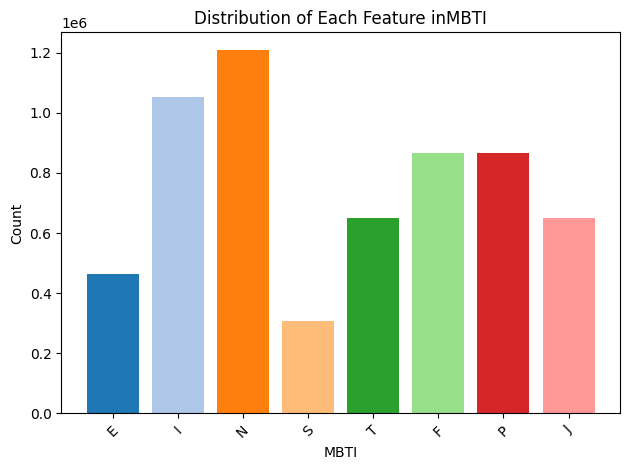

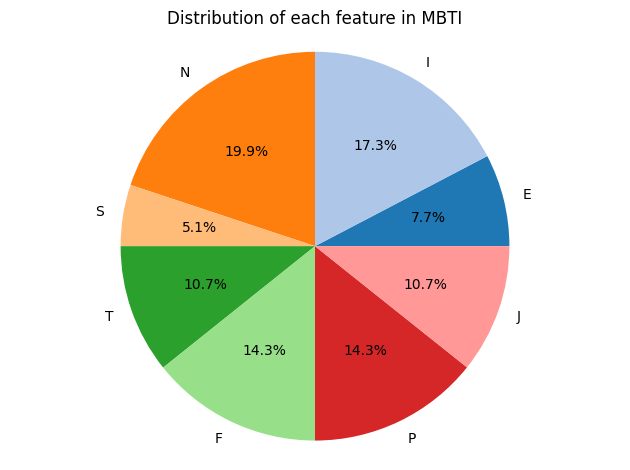

In [ ]:
colors = plt.get_cmap('tab20')(range(len(list(indi_char_count.values()))))

#plot bar plot
plt.figure()
# Access keys and values directly from the dictionary
plt.bar(list(indi_char_count.keys()), list(indi_char_count.values()), color=colors)
plt.title('Distribution of Each Feature inMBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(list(indi_char_count.values()), labels=list(indi_char_count.keys()), colors=colors, autopct='%1.1f%%') # Use keys for labels
plt.title('Distribution of each feature in MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# Undersample to balance 16‑class
X = df[["post"]].values
y = df["label_16"].values
rus = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
X_res, y_res = rus.fit_resample(X, y)

# rebuild DataFrame after resampling
df_resampled = pd.DataFrame({
    "posts": X_res.ravel(),
    "label_16": y_res
})

In [ ]:
# rebuild DataFrame after resampling
df_resampled = pd.DataFrame({
    "posts": X_res.ravel(),
    "label_16": y_res
})

In [ ]:
# regenerate the four binary dims
df_resampled['type'] = le.inverse_transform(df_resampled["label_16"])
df_resampled['E'] = df_resampled["type"].str[0].map({"e":1, "i":0})
df_resampled['N'] = df_resampled["type"].str[1].map({"n":1, "s":0})
df_resampled['T'] = df_resampled["type"].str[2].map({"t":1, "f":0})
df_resampled['P'] = df_resampled["type"].str[3].map({"p":1, "j":0})

In [ ]:
df_resampled

,posts,label_16,type,E,N,T,P
0,moveee this was my jam,0,enfj,1,1,0,0
1,pls no,0,enfj,1,1,0,0
2,as a fan it is hard for me to say this but i l...,0,enfj,1,1,0,0
3,"bob saget and oprah, apparently. i've heard pe...",0,enfj,1,1,0,0
4,i know what all of you are thinking and none o...,0,enfj,1,1,0,0
...,...,...,...,...,...,...,...
225323,yall never believe me when i say i get bitches...,15,istp,0,0,1,1
225324,"can't draw, can't write a song, can't make som...",15,istp,0,0,1,1
225325,social media wanna look minimal so bad,15,istp,0,0,1,1
225326,i stopped caring when i wanted more bacon.,15,istp,0,0,1,1


In [ ]:
df_resampled['E'].value_counts()

,count
E,
1,112664
0,112664


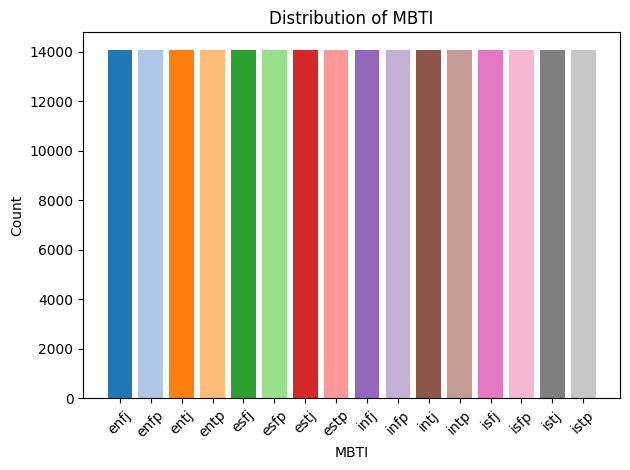

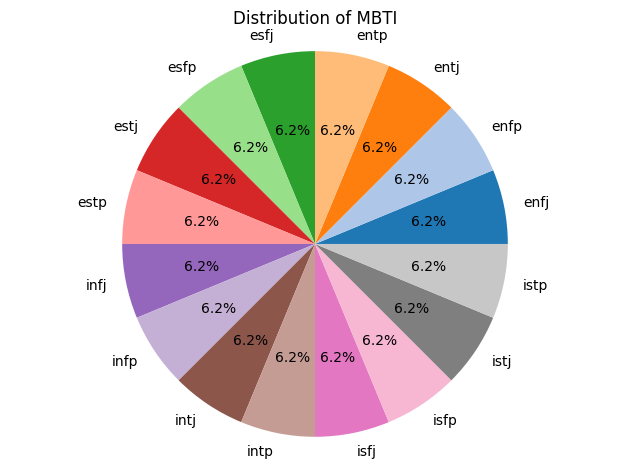

In [ ]:
counts = df_resampled['type'].value_counts()
# The variable 'sizes' was not defined.
# Assuming it should represent the counts of each MBTI type, we can replace it with 'counts.values'
colors = plt.get_cmap('tab20')(range(len(counts.values)))

#plot bar plot
plt.figure()
plt.bar(counts.index.astype(str), counts.values, color=colors)
plt.title('Distribution of MBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(counts.values, labels=counts.index.astype(str),colors=colors, autopct='%1.1f%%')
plt.title('Distribution of MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# collect amount of each mbti
total = len(df_resampled)
indi_char_count2 = {
    'E': int(df_resampled['E'].sum()),
    'I': total - int(df_resampled['E'].sum()),
    'N': int(df_resampled['N'].sum()),
    'S': total - int(df_resampled['N'].sum()),
    'T': int(df_resampled['T'].sum()),
    'F': total - int(df_resampled['T'].sum()),
    'P': int(df_resampled['P'].sum()),
    'J': total - int(df_resampled['P'].sum())
}

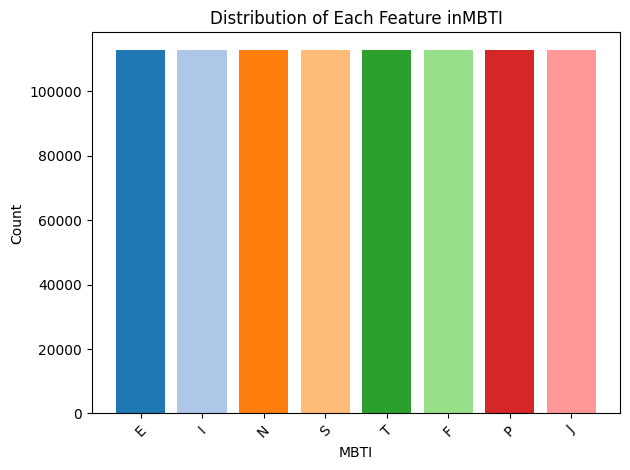

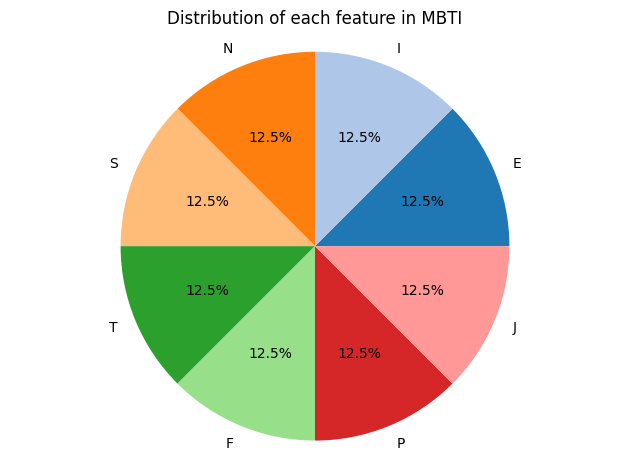

In [ ]:
colors = plt.get_cmap('tab20')(range(len(list(indi_char_count2.values()))))

#plot bar plot
plt.figure()
# Access keys and values directly from the dictionary
plt.bar(list(indi_char_count2.keys()), list(indi_char_count2.values()), color=colors)
plt.title('Distribution of Each Feature inMBTI')
plt.xlabel('MBTI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot pie chart
plt.figure()
plt.pie(list(indi_char_count2.values()), labels=list(indi_char_count2.keys()), colors=colors, autopct='%1.1f%%') # Use keys for labels
plt.title('Distribution of each feature in MBTI')
plt.axis('equal')
plt.tight_layout()
plt.show()

### Tokenization/Embedding/Train-test split

***Check the max len after tokenization***

In [ ]:
# tokenizer= BertTokenizerFast.from_pretrained('bert-base-uncased')
# texts = df_resampled['posts'].tolist()
# lengths = [
#     len(tokenizer.encode(text, add_special_tokens=True))
#     for text in texts
# ]

# length_series = pd.Series(lengths, name='token length')

# print(length_series.describe(percentiles=[.05, .25, .5, .75, .95, .99]))
# plt.figure()
# plt.hist(lengths, bins=range(0,255,16))
# plt.title("Distribution of Tokenized Post Lengths")
# plt.xlabel("Token Length")
# plt.ylabel("Number of Posts")
# plt.tight_layout()
# plt.show()

***95%          52.000000***

*** **加粗文字**Train, test, val split***

In [ ]:
train_df, temp_df = train_test_split(
    df_resampled, test_size=0.30, stratify=df_resampled["label_16"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label_16"], random_state=42
)

In [ ]:
# Tokenize
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def tokenize_df(data):
    return tokenizer(
        data["posts"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=64,
        return_tensors="pt"
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_tok = tokenize_df(train_df)
val_tok   = tokenize_df(val_df)
test_tok  = tokenize_df(test_df)

In [ ]:
# Dataset + DataLoader
class MBTIDataset(Dataset):
    def __init__(self, encodings, df):
        self.encodings = encodings
        # 16-class labels
        self.labels_16 = df["label_16"].values
        # 4-dim binary labels
        self.labels_4  = df[["E","N","T","P"]].values.astype(np.float32)

    def __len__(self):
        return len(self.labels_16)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels_16"] = torch.tensor(self.labels_16[idx], dtype=torch.long)
        item["labels_4"]  = torch.tensor(self.labels_4[idx], dtype=torch.float)
        return item

train_dataset = MBTIDataset(train_tok, train_df)
val_dataset   = MBTIDataset(val_tok,   val_df)
test_dataset  = MBTIDataset(test_tok,  test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)
test_loader  = DataLoader(test_dataset,  batch_size=32)

In [ ]:
tokenizer.save_pretrained(file_path)

('/content/gdrive/My Drive/BT 5153 Final Project/tokenizer_config.json',
 '/content/gdrive/My Drive/BT 5153 Final Project/special_tokens_map.json',
 '/content/gdrive/My Drive/BT 5153 Final Project/vocab.txt',
 '/content/gdrive/My Drive/BT 5153 Final Project/added_tokens.json',
 '/content/gdrive/My Drive/BT 5153 Final Project/tokenizer.json')

# BERT+MLP

***16 classification***

In [ ]:
class MBTIClassifier(nn.Module):
  def __init__(self,pretrained_model_name="bert-base-uncased", hidden_dim1 = 1024,hidden_dim2=512, hidden_dim3=256, num_classes=16, drop_out_rate=0.05, freeze_bert_layers=0):
    super(MBTIClassifier, self).__init__()
    #load pretrained BERT
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    #freeze N layers parameters, acccelerate convergence
    for name, param in self.bert.named_parameters():
      layer_num = None
      if name.startswith('encoder.layer'):
        layer_num = name.split('.')[2]
      if layer_num is not None and int(layer_num) < freeze_bert_layers:
        param.requires_grad = False
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size, hidden_dim1),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim2, hidden_dim3),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim3, num_classes)
    )
    # forward propagation
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    cls_vector = outputs.last_hidden_state[:, 0, :]  # shape=(batch_size, hidden_size)
    logits = self.classifier(cls_vector)            # shape=(batch_size, num_classes)
    return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MBTIClassifier().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
total_steps = len(train_loader) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def train_epoch(loader):
    model.train()
    losses, preds, labels = [], [], []
    for batch in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask      = batch["attention_mask"].to(device)
        y_true    = batch["labels_16"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, y_true)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds.extend(logits.argmax(dim=1).cpu().numpy())
        labels.extend(y_true.cpu().numpy())

    return np.mean(losses), accuracy_score(labels, preds), f1_score(labels, preds, average="macro")

def eval_epoch(loader):
    model.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask      = batch["attention_mask"].to(device)
            y_true    = batch["labels_16"].to(device)

            logits = model(input_ids, mask)
            loss = criterion(logits, y_true)
            losses.append(loss.item())

            preds.extend(logits.argmax(dim=1).cpu().numpy())
            labels.extend(y_true.cpu().numpy())

    # basic indexes
    avg_loss = np.mean(losses)
    acc      = accuracy_score(labels, preds)
    f1       = f1_score(labels, preds, average="macro")
    prec     = precision_score(labels, preds, average="macro")
    rec      = recall_score(labels, preds, average="macro")

    # confusion matrix
    cm = confusion_matrix(labels, preds)


    class_names = le.classes_.tolist()
    report = classification_report(labels, preds, target_names=class_names)

    return {
        "loss":      avg_loss,
        "accuracy":  acc,
        "f1_macro":  f1,
        "prec_macro":prec,
        "rec_macro": rec,
        "confusion_matrix": cm,
        "report":    report
    }

***Train and save the models***

In [ ]:
best_accuracy = 0
best_state_dict = None
num_epochs = 3

for epoch in range(num_epochs):
    tr_loss, tr_acc, tr_f1 = train_epoch(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f} | Train F1: {tr_f1:.4f}")
    val_eval = eval_epoch(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_eval['loss']:.4f} | Val Acc: {val_eval['accuracy']:.4f} | Val F1: {val_eval['f1_macro']:.4f}")
    print(f"..............................................................................................")

    if val_eval['accuracy'] > best_accuracy:
        best_accuracy = val_eval['accuracy']
        best_state_dict = copy.deepcopy(model.state_dict())
        print(f"New best model found at epoch {epoch}, the accuracy is {val_eval['accuracy']}.")


In [ ]:
# save model path
save_path = f"{file_path}/best_mbti_classifier.pt"
torch.save(best_state_dict, save_path)
print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved to {save_path}")

state_dict_json = {k: v.cpu().tolist() for k, v in best_state_dict.items()}
json_path = f"{file_path}/best_mbti_classifier.json"
with open(json_path, "w", encoding="utf-8") as jf:
    json.dump(state_dict_json, jf)

print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved as JSON to {json_path}")

NameError: name 'best_state_dict' is not defined

In [ ]:
model = MBTIClassifier(num_classes=16).to(device)
model.load_state_dict(torch.load("/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_classifier.pt"))

<All keys matched successfully>

In [ ]:
text_eval = eval_epoch(test_loader)
print(f"Test ▶ Loss: {text_eval['loss']:.4f}, Accuracy: {text_eval['accuracy']:.4f}, F1: {text_eval['f1_macro']:.4f}, Precision: {text_eval['prec_macro']:.4f}, Recall: {text_eval['rec_macro']:.4f}")
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print(text_eval['report'])
print("-------------------------------------------------------------------------------------------------------------------------------------------------------")
print(text_eval['confusion_matrix'])

Test ▶ Loss: 2.7839, Accuracy: 0.1346, F1: 0.1325, Precision: 0.1398, Recall: 0.1346
-------------------------------------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

        enfj       0.09      0.18      0.12      2112
        enfp       0.14      0.08      0.10      2112
        entj       0.14      0.10      0.12      2113
        entp       0.13      0.10      0.11      2112
        esfj       0.15      0.19      0.16      2113
        esfp       0.11      0.23      0.15      2113
        estj       0.20      0.16      0.18      2112
        estp       0.16      0.18      0.17      2113
        infj       0.14      0.10      0.12      2113
        infp       0.15      0.14      0.14      2112
        intj       0.16      0.11      0.13      2112
        intp       0.15      0.12      0.13      2113
        isfj       0.13      0.18      0.15      2112
      

***4 classification: Try building classification model on different dimensions(Energe, Information, Decision and Execution)***

In [ ]:
class MBTIClassifier(nn.Module):
  def __init__(self, pretrained_model_name="bert-base-uncased",
               hidden_dim1=1024, hidden_dim2=512, hidden_dim3=256,
               num_classes=16, drop_out_rate=0.05, freeze_bert_layers=0):
    super(MBTIClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(pretrained_model_name)
    for name, param in self.bert.named_parameters():
      layer_num = None
      if name.startswith('encoder.layer'):
        layer_num = name.split('.')[2]
      if layer_num is not None and int(layer_num) < freeze_bert_layers:
        param.requires_grad = False
    self.classifier = nn.Sequential(
        nn.Linear(self.bert.config.hidden_size, hidden_dim1),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim1, hidden_dim2),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim2, hidden_dim3),
        nn.ReLU(),
        nn.Dropout(drop_out_rate),
        nn.Linear(hidden_dim3, num_classes)
    )

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    cls_vector = outputs.last_hidden_state[:, 0, :]
    logits = self.classifier(cls_vector)
    return logits

In [ ]:
def train_epoch_binary(loader, dim_idx):
    model.train()
    losses, preds, labels = [], [], []
    for batch in tqdm.tqdm(loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        mask      = batch["attention_mask"].to(device)
        y_true    = batch["labels_4"][:, dim_idx].unsqueeze(1).to(device)  # shape: (batch_size, 1)

        logits = model(input_ids, mask)
        loss = criterion(logits, y_true)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        losses.append(loss.item())
        preds.extend((torch.sigmoid(logits).detach().cpu().numpy() > 0.5).astype(int))
        labels.extend(y_true.cpu().numpy())

    return np.mean(losses), accuracy_score(labels, preds), f1_score(labels, preds)

In [ ]:
def eval_epoch_binary(loader, dim_idx):
    model.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask      = batch["attention_mask"].to(device)
            y_true    = batch["labels_4"][:, dim_idx].unsqueeze(1).to(device)

            logits = model(input_ids, mask)
            loss = criterion(logits, y_true)
            losses.append(loss.item())

            preds.extend((torch.sigmoid(logits).detach().cpu().numpy() > 0.5).astype(int))
            labels.extend(y_true.cpu().numpy())

    return {
        "loss": np.mean(losses),
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "report": classification_report(labels, preds),
        "confusion_matrix": confusion_matrix(labels, preds)
    }

In [ ]:
def test_eval_binary(loader, model, dim_idx=0):
    model.eval()
    losses, preds, labels = [], [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask      = batch["attention_mask"].to(device)
            y_true    = batch["labels_4"][:, dim_idx].to(device)

            logits = model(input_ids, mask).squeeze()
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend((probs > 0.5).astype(int))
            labels.extend(y_true.cpu().numpy())

    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec  = recall_score(labels, preds)
    f1   = f1_score(labels, preds)
    cm   = confusion_matrix(labels, preds)
    report = classification_report(labels, preds, target_names=["0", "1"])

    print("▶ Test Set Evaluation")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

In [ ]:
# Training on dimension Energy(E or I)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n==== Training on dimension: Energy(E or I) ====")
dim_idx = 0
model = MBTIClassifier(num_classes=1).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0.1 * len(train_loader) * 3,
    num_training_steps=len(train_loader) * 3
)
criterion = nn.BCEWithLogitsLoss()

best_f1 = 0
for epoch in range(3):
    tr_loss, tr_acc, tr_f1 = train_epoch_binary(train_loader, dim_idx=dim_idx)
    val_eval = eval_epoch_binary(val_loader, dim_idx=dim_idx)
    print(f"Epoch {epoch+1} | Train F1: {tr_f1:.4f} | Val F1: {val_eval['f1']:.4f}")
    if val_eval["f1"] > best_f1:
        best_f1 = val_eval["f1"]
        best_state_dict = copy.deepcopy(model.state_dict())

save_path = f"{file_path}/best_mbti_E.pt"
torch.save(best_state_dict, save_path)
print(f"Best model for E saved to {save_path}")

state_dict_json = {k: v.cpu().tolist() for k, v in best_state_dict.items()}
json_path = f"{file_path}/best_mbti_E.json"
with open(json_path, "w", encoding="utf-8") as jf:
    json.dump(state_dict_json, jf)

print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved as JSON to {json_path}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_E = MBTIClassifier(num_classes=1).to(device)
model_E.load_state_dict(torch.load("/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_E.pt"))
test_eval_binary(test_loader, model_E, dim_idx=0)

▶ Test Set Evaluation
Accuracy : 0.5608
Precision: 0.5454
Recall   : 0.7314
F1 Score : 0.6248
Confusion Matrix:
 [[ 6596 10304]
 [ 4540 12360]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.39      0.47     16900
           1       0.55      0.73      0.62     16900

    accuracy                           0.56     33800
   macro avg       0.57      0.56      0.55     33800
weighted avg       0.57      0.56      0.55     33800



In [ ]:
print("\n==== Training on dimension: Information(N or S) ====")
dim_idx = 1
model = MBTIClassifier(num_classes=1).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0.1 * len(train_loader) * 3,
    num_training_steps=len(train_loader) * 3
)
criterion = nn.BCEWithLogitsLoss()

best_f1 = 0
for epoch in range(3):
    tr_loss, tr_acc, tr_f1 = train_epoch_binary(train_loader, dim_idx=dim_idx)
    val_eval = eval_epoch_binary(val_loader, dim_idx=dim_idx)
    print(f"Epoch {epoch+1} | Train F1: {tr_f1:.4f} | Val F1: {val_eval['f1']:.4f}")
    if val_eval["f1"] > best_f1:
        best_f1 = val_eval["f1"]
        best_state_dict = copy.deepcopy(model.state_dict())

save_path = f"{file_path}/best_mbti_N.pt"
torch.save(best_state_dict, save_path)
print(f"Best model for N saved to {save_path}")

state_dict_json = {k: v.cpu().tolist() for k, v in best_state_dict.items()}
json_path = f"{file_path}/best_mbti_N.json"
with open(json_path, "w", encoding="utf-8") as jf:
    json.dump(state_dict_json, jf)

print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved as JSON to {json_path}")


==== Training on dimension: Information(N or S) ====


100%|██████████| 4930/4930 [06:49<00:00, 12.04it/s]


Epoch 1 | Train F1: 0.4974 | Val F1: 0.5063


100%|██████████| 4930/4930 [06:49<00:00, 12.03it/s]


Epoch 2 | Train F1: 0.5583 | Val F1: 0.5060


100%|██████████| 4930/4930 [06:50<00:00, 12.00it/s]


Epoch 3 | Train F1: 0.6488 | Val F1: 0.5309
Best model for N saved to /content/gdrive/My Drive/BT 5153 Final Project/best_mbti_N.pt
▶ Training complete. Best model (val accuracy=0.1324) saved as JSON to /content/gdrive/My Drive/BT 5153 Final Project/best_mbti_N.json


In [ ]:
model_N = MBTIClassifier(num_classes=1).to(device)
model_N.load_state_dict(torch.load("/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_N.pt"))
test_eval_binary(test_loader, model_N, dim_idx=1)

▶ Test Set Evaluation
Accuracy : 0.5699
Precision: 0.5829
Recall   : 0.4908
F1 Score : 0.5329
Confusion Matrix:
 [[10967  5934]
 [ 8605  8294]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.65      0.60     16901
           1       0.58      0.49      0.53     16899

    accuracy                           0.57     33800
   macro avg       0.57      0.57      0.57     33800
weighted avg       0.57      0.57      0.57     33800



In [ ]:
print("\n==== Training on dimension: Decision(T or F) ====")
dim_idx = 2  # 对应 N
model = MBTIClassifier(num_classes=1).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0.1 * len(train_loader) * 3,
    num_training_steps=len(train_loader) * 3
)
criterion = nn.BCEWithLogitsLoss()

best_f1 = 0
for epoch in range(3):
    tr_loss, tr_acc, tr_f1 = train_epoch_binary(train_loader, dim_idx=dim_idx)
    val_eval = eval_epoch_binary(val_loader, dim_idx=dim_idx)
    print(f"Epoch {epoch+1} | Train F1: {tr_f1:.4f} | Val F1: {val_eval['f1']:.4f}")
    if val_eval["f1"] > best_f1:
        best_f1 = val_eval["f1"]
        best_state_dict = copy.deepcopy(model.state_dict())

save_path = f"{file_path}/best_mbti_T.pt"
torch.save(best_state_dict, save_path)
print(f"Best model for T saved to {save_path}")

state_dict_json = {k: v.cpu().tolist() for k, v in best_state_dict.items()}
json_path = f"{file_path}/best_mbti_T.json"
with open(json_path, "w", encoding="utf-8") as jf:
    json.dump(state_dict_json, jf)

print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved as JSON to {json_path}")

In [ ]:
model_T = MBTIClassifier(num_classes=1).to(device)
model_T.load_state_dict(torch.load("/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_T.pt"))
test_eval_binary(test_loader, model_T, dim_idx=2)

▶ Test Set Evaluation
Accuracy : 0.5718
Precision: 0.5692
Recall   : 0.5909
F1 Score : 0.5798
Confusion Matrix:
 [[9342 7558]
 [6914 9986]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.55      0.56     16900
           1       0.57      0.59      0.58     16900

    accuracy                           0.57     33800
   macro avg       0.57      0.57      0.57     33800
weighted avg       0.57      0.57      0.57     33800



In [ ]:
print("\n==== Training on dimension: Lifestyle(P or J) ====")
dim_idx = 3  # 对应 N
model = MBTIClassifier(num_classes=1).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0.1 * len(train_loader) * 3,
    num_training_steps=len(train_loader) * 3
)
criterion = nn.BCEWithLogitsLoss()

best_f1 = 0
for epoch in range(3):
    tr_loss, tr_acc, tr_f1 = train_epoch_binary(train_loader, dim_idx=dim_idx)
    val_eval = eval_epoch_binary(val_loader, dim_idx=dim_idx)
    print(f"Epoch {epoch+1} | Train F1: {tr_f1:.4f} | Val F1: {val_eval['f1']:.4f}")
    if val_eval["f1"] > best_f1:
        best_f1 = val_eval["f1"]
        best_state_dict = copy.deepcopy(model.state_dict())

save_path = f"{file_path}/best_mbti_P.pt"
torch.save(best_state_dict, save_path)
print(f"Best model for P saved to {save_path}")

state_dict_json = {k: v.cpu().tolist() for k, v in best_state_dict.items()}
json_path = f"{file_path}/best_mbti_P.json"
with open(json_path, "w", encoding="utf-8") as jf:
    json.dump(state_dict_json, jf)

print(f"▶ Training complete. Best model (val accuracy={best_accuracy:.4f}) saved as JSON to {json_path}")

In [ ]:
model_P = MBTIClassifier(num_classes=1).to(device)
model_P.load_state_dict(torch.load("/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_P.pt"))
test_eval_binary(test_loader, model_P, dim_idx=3)

▶ Test Set Evaluation
Accuracy : 0.5599
Precision: 0.5510
Recall   : 0.6478
F1 Score : 0.5955
Confusion Matrix:
 [[ 7977  8922]
 [ 5952 10949]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.47      0.52     16899
           1       0.55      0.65      0.60     16901

    accuracy                           0.56     33800
   macro avg       0.56      0.56      0.56     33800
weighted avg       0.56      0.56      0.56     33800



Combination of the dimension binary model

In [ ]:
model_paths = {
    "E": "/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_E.pt",
    "N": "/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_N.pt",
    "T": "/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_T.pt",
    "P": "/content/gdrive/My Drive/BT 5153 Final Project/best_mbti_P.pt"
}

In [ ]:
dim_models = {}
dim_names = ['E', 'N', 'T', 'P']
for i, name in enumerate(dim_names):
    model = MBTIClassifier(num_classes=1).to(device)
    model.load_state_dict(torch.load(model_paths[name]))
    model.eval()
    dim_models[i] = model

In [ ]:
from sklearn.metrics import accuracy_score

def eval_4dim_joint(models_dict, loader):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels_4 = batch["labels_4"].cpu().numpy()  # shape: (batch, 4)

            preds = []
            for dim_idx in range(4):
                model = models_dict[dim_idx]
                logits = model(input_ids, mask).squeeze()
                prob = torch.sigmoid(logits).cpu().numpy()
                pred_dim = (prob > 0.5).astype(int)
                preds.append(pred_dim)

            # shape: (4, batch) -> transpose -> (batch, 4)
            preds = np.stack(preds, axis=1)
            all_preds.append(preds)
            all_labels.append(labels_4)

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    exact_match = np.all(all_preds == all_labels, axis=1)
    exact_accuracy = np.mean(exact_match)

    print("▶ 4-Dimension Joint Accuracy (Exact Match):", f"{exact_accuracy:.4f}")
    return all_preds, all_labels, exact_accuracy

In [ ]:
preds_4d, labels_4d, acc = eval_4dim_joint(dim_models, test_loader)

▶ 4-Dimension Joint Accuracy (Exact Match): 0.1193


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# binary vector -> MBTI string
def binary_array_to_mbti(arr):
    dim_map = [("E", "I"), ("N", "S"), ("T", "F"), ("P", "J")]
    mbti_list = []
    for row in arr:
        mbti = "".join([dim_map[i][int(bit)] for i, bit in enumerate(row)])
        mbti_list.append(mbti)
    return mbti_list

In [ ]:
y_pred_mbti = binary_array_to_mbti(preds_4d)
y_true_mbti = binary_array_to_mbti(labels_4d)

In [ ]:
from sklearn.metrics import classification_report

print("🔍 Per-MBTI Classification Report:")
print(classification_report(y_true_mbti, y_pred_mbti, digits=4))

🔍 Per-MBTI Classification Report:
              precision    recall  f1-score   support

        ENFJ     0.1296    0.0516    0.0738      2113
        ENFP     0.1802    0.0483    0.0762      2112
        ENTJ     0.1251    0.0577    0.0790      2113
        ENTP     0.1720    0.1075    0.1323      2112
        ESFJ     0.1297    0.1477    0.1381      2113
        ESFP     0.1280    0.1496    0.1380      2112
        ESTJ     0.1574    0.0966    0.1197      2112
        ESTP     0.1196    0.0715    0.0895      2113
        INFJ     0.0946    0.2220    0.1326      2113
        INFP     0.1434    0.1165    0.1286      2112
        INTJ     0.0968    0.2986    0.1462      2113
        INTP     0.1276    0.1396    0.1333      2113
        ISFJ     0.1137    0.1051    0.1092      2112
        ISFP     0.1203    0.1500    0.1335      2113
        ISTJ     0.1182    0.0516    0.0719      2112
        ISTP     0.1225    0.0956    0.1074      2112

    accuracy                         0.1193   